# Actividad 3: Mini proyecto - evaluación de clasificadores

Un clasificador en ciencia de datos es un algoritmo o modelo que recibe un conjunto de datos discretos y/o continuos (descriptores) y retorna un valor categórico (la clase). En esta actividad, usaremos algunos clasificadores simples, como la regresión logística y Naive Bayes. Para entrenar estos modelos, usted podrá seleccionar entre dos posibles bases de datos, una asociada a la clasificación de estrellas variables y otra asociada a la identificación de lesiones cutáneas.

Los clasificadores deben desarrollarse de manera que no se sobreajuste a los datos de entrenamiento y puedan obtener buenos resultados con datos no vistos. Es decir, tal como estudiamos en la actividad anterior, debemos construir modelos que generalicen adecuadamente. Para seleccionar el modelo adecuado, usted deberá presentar los resultados utilizando distintas métricas (accuracy, recall, precision y F1-score) en una estrategia de validación (hold-out o cross-validation).


## 2	Bases de datos
### 2.1	Opción 1: estrellas variables ([descargar](https://drive.usercontent.google.com/download?id=1gzDI8kYU-su66Kjor62wlI-mX3LgBgjn&export=download&authuser=0) )

Las estrellas variables son objetos que cambian su brillo en el tiempo. El origen de su variabilidad puede ser originado por objetos pasando frente a ellos (planetas, asteroides, manchas solares u otra estrella) o causados por procesos físicos en su interior.

Las observaciones de estas estrellas no son constantes, ya que no siempre pueden ser observadas producto de las estaciones, condiciones climáticas, fases de la luna, entre otros factores. Esto hace que las series de tiempo resultantes no tengan un largo fijo. Además, el muestreo es distinto para cada estrella. Para poder usar la información en un clasificador automático, se calculan descriptores que resumen la información en un vector de largo fijo. Esta información puede ser de origen físico, como la periodicidad, o estadístico, como la dispersión en torno a la media.

En esta actividad usarán descriptores estadísticos ya calculados para clasificar estrellas variables.


<hr style="border: 2px solid orange;">

### 2.2	Opción 2: Lesiones cutaneas ([descargar](https://drive.google.com/file/d/1nzevKi8CyZjmpXoBDRMffLUsCnB25pD-/view) )

El conjunto de datos PAD-UFES-20 fue recopilado junto con el Programa de asistencia dermatológica y quirúrgica de la Universidad Federal de Espirito Santo, que es un programa sin fines de lucro que proporciona tratamiento gratuito de lesiones cutáneas, en particular, a personas de bajos ingresos que no pueden permitirse un tratamiento privado.

El conjunto de datos consta de 2,298 muestras de seis tipos diferentes de lesiones cutáneas. Cada muestra consta de una imagen clínica y características clínicas, incluida la edad del paciente, la ubicación de la lesión cutánea, el diámetro de la lesión cutánea, entre otras.

Las lesiones cutáneas son: carcinoma de células basales (BCC), carcinoma de células escamosas (SCC), queratosis actínica (ACK), queratosis seborreica (SEK), enfermedad de Bowen (BOD), melanoma (MEL) y nevus (NEV). Como la enfermedad de Bowen se considera SCC, se agrupa, lo que da como resultado seis lesiones cutáneas en el conjunto de datos, tres cánceres de piel (BCC, MEL y SCC) y tres enfermedades de la piel (ACK, NEV y SEK). Todos los BCC, SCC y MEL están probados mediante biopsia. Los restantes podrán tener diagnóstico clínico según consenso de un grupo de dermatólogos. En total, aproximadamente el 58% de las muestras de este conjunto de datos están probadas mediante biopsia.

<hr style="border: 2px solid orange;">


## 3	Instrucciones del mini proyecto
### 3.1	Transformación e imputación de datos (25 puntos)
0 ptos Abrir entorno de programación, de preferencia utilizar Visual studio code. Importe las librerías pandas, searborn, matplotlib, numpy y sklearn. Le recomendamos usar un ambiente de conda específico para el curso.


In [1]:
#from google.colab import drive
#drive.mount('/content/drive')
#%cd '/content/drive/MyDrive/Colab Notebooks/Maching_Learning/Diplomado/Act_3'

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/Maching_Learning/Diplomado/Act_3


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split

2 ptos Cargar la base de datos (Gaia NaN.csv o metadato.csv ).  Cree una función que permita cargar la base de datos bajo diferentes condiciones. Los argumentos de esta función deben ser: (i) un string con el nombre del directorio donde se encuentre la base de datos, (ii) una variable booleana que indique si se trabajara con una muestra o con la base de datos completa y (iii) un argumento que reciba las columnas con las que se pueda trabajar en una lista. Usted puede agregar nuevos argumentos que den mayor flexibilidad a la carga de datos. Recuerde verificar el tipo de variable reconocido por pandas.


In [3]:
def cargar_datos(ruta:str, muestra:bool, columnas:list, sep, porcentaje:float=0.1) -> pd.DataFrame:

    if not os.path.exists(ruta):
        raise FileNotFoundError(f'No se encontró el archivo en la ruta: {ruta}')
    df = pd.read_csv(ruta, sep=sep)

    if muestra:
        df = df.sample(frac=porcentaje, random_state=42)
    df_final = df[columnas]

    return df_final

# Formatear el UNK a NaN cuando sean 3 valores, y los otros dos sean True o False
def cambiar_UNK_a_nan(df:pd.DataFrame):
    pd.set_option('future.no_silent_downcasting', True)

    columnas = [col for col in df.columns.tolist() if df[col].dtype == 'object']
    col_con_UNK = [col for col in columnas if df[col].astype(str).str.contains('UNK').any()]
    col_TF = [x for x in columnas if set(df[x].dropna().unique()) == {'True', 'False',}]
    col_hat_true_false = list(set(col_con_UNK + col_TF))

    # convertir las columnas de UNK a NaN
    for col in col_hat_true_false:
        df.loc[:, col] = df[col].replace({'UNK': np.nan, 'True': True, 'False': False})
    return df


# Función que transforma las columnas de True y False a 1 y 0
def transf_true_false(df:pd.DataFrame):
    columnas = df.columns.tolist()
    # quiero poner en columnas booleanas los valores que son True y False en 1 y 0, validando que sean o True o False, donde los NaN no se consideran
    col_true_false = [x for x in columnas if (df[x].dtype == 'object' or df[x].dtype == 'bool') and (set(df[x].dropna().unique()) == {True, False,})]
    # convertir las columnas de True y False a 1 y 0
    for col in col_true_false:
        df[col] = df[col].map({True: 1, False: 0})
    return df


In [4]:
# leer sólo las columnas de los archivos que podríamos van a utilizar

ruta_cancer = 'data/metadatos.csv'

col_c = pd.read_csv(ruta_cancer, nrows=0, sep=',').columns.to_list()

print(f'Columnas de lesiones cutaneaas: {col_c}')

# Vamos a usar las columnas del archivo de cancer, y sólo voy a usar estas columnas, pq no necesito 'patient_id', 'lesion_id','img_id'
column = ['smoke', 'drink', 'background_father', 'background_mother', 'age', 'pesticide', 'gender', 'skin_cancer_history', 'cancer_history', 'has_piped_water', 'has_sewage_system', 'fitspatrick', 'region', 'diameter_1', 'diameter_2', 'diagnostic', 'itch', 'grew', 'hurt', 'changed', 'bleed', 'elevation', 'biopsed']

df = cargar_datos(ruta=ruta_cancer, muestra=True, columnas=column, sep=',', porcentaje=0.50)


Columnas de lesiones cutaneaas: ['patient_id', 'lesion_id', 'smoke', 'drink', 'background_father', 'background_mother', 'age', 'pesticide', 'gender', 'skin_cancer_history', 'cancer_history', 'has_piped_water', 'has_sewage_system', 'fitspatrick', 'region', 'diameter_1', 'diameter_2', 'diagnostic', 'itch', 'grew', 'hurt', 'changed', 'bleed', 'elevation', 'img_id', 'biopsed']


In [5]:
df = cambiar_UNK_a_nan(df) # convertir los valores de UNK a NaN y a True y False booleanos
df = transf_true_false(df)  # transformar las columnas de True y False a 1 y 0

In [6]:
# Función de apoyo para obtener los valores únicos y % de nulos de un dataframe para eligir las columnas que quiero
def obtener_analisis(df:pd.DataFrame):
    unicos = {}
    for col in df.columns.tolist():
        lista_unique = df[col].unique().tolist()
        unicos[col] = lista_unique

    porc_nulos = {}
    for col in df.columns.tolist():
        nulo = df[col].isnull().sum()
        porc_nulos[col] = round(float(nulo/df.shape[0]), 2)

    datos_analisis = {
                     'Columna': list(unicos.keys()),
                     'Valor único': list(unicos.values()),
                     'Porcentaje nulos': list(porc_nulos.values())
                     }
    df_datos = pd.DataFrame(datos_analisis)
    return df_datos

df_analisis = obtener_analisis(df)
df_analisis


,Columna,Valor único,Porcentaje nulos
0,smoke,"[nan, 0.0, 1.0]",0.33
1,drink,"[nan, 0.0, 1.0]",0.33
2,background_father,"[nan, POMERANIA, GERMANY, ITALY, BRAZIL, NETHE...",0.39
3,background_mother,"[nan, POMERANIA, GERMANY, ITALY, BRAZIL, FRANC...",0.38
4,age,"[39, 58, 56, 71, 79, 85, 46, 61, 78, 83, 80, 5...",0.00
5,pesticide,"[nan, 1.0, 0.0]",0.33
6,gender,"[nan, FEMALE, MALE]",0.33
7,skin_cancer_history,"[nan, 1.0, 0.0]",0.33
8,cancer_history,"[nan, 1.0, 0.0]",0.33
9,has_piped_water,"[nan, 0.0, 1.0]",0.33


In [ ]:
# Vamos a guardar el archivo transformado
# df.to_csv('data/cancer_transformado.csv', index=False)

<div style="height: 5px; background: linear-gradient(to right, cyan, lime); margin-bottom: 20px;"></div>


In [7]:
from sklearn.preprocessing import LabelEncoder

# Codificar las columnas categóricas de mi target diagnostic
def codificar_label_encoder(df:pd.DataFrame, col_target:str):
    encoder = LabelEncoder()
    new_col = f"{col_target}_encoded"
    df[new_col] = encoder.fit_transform(df[col_target])
    lista_categorias = encoder.classes_  #  lista ordenada de las clases únicas encontradas en el descriptor ordenadas alfabéticamente igual q el unique() pero ordenado
    lista_num = encoder.transform(encoder.classes_)
    dic_categ_num = dict(zip(lista_categorias, lista_num))
    dic_categ_num = {k: int(v) for k, v in dic_categ_num.items()}
    return df, dic_categ_num, new_col

df, label_num, col_encoded_target = codificar_label_encoder(df, 'diagnostic')
print(f'Columna codificada: {col_encoded_target}')
print(f'Label codificado: {label_num}')

df.head()

Columna codificada: diagnostic_encoded
Label codificado: {'ACK': 0, 'BCC': 1, 'MEL': 2, 'NEV': 3, 'SCC': 4, 'SEK': 5}


,smoke,drink,background_father,background_mother,age,pesticide,gender,skin_cancer_history,cancer_history,has_piped_water,...,diameter_2,diagnostic,itch,grew,hurt,changed,bleed,elevation,biopsed,diagnostic_encoded
1085,NaN,NaN,NaN,NaN,39,NaN,NaN,NaN,NaN,NaN,...,NaN,NEV,0,0.0,0.0,0.0,0.0,1.0,0,3
2296,0.0,0.0,POMERANIA,POMERANIA,58,1.0,FEMALE,1.0,1.0,0.0,...,4.0,BCC,1,0.0,0.0,0.0,0.0,1.0,1,1
208,0.0,0.0,GERMANY,GERMANY,56,1.0,FEMALE,1.0,0.0,1.0,...,3.0,BCC,1,1.0,0.0,0.0,0.0,1.0,1,1
1178,0.0,0.0,POMERANIA,POMERANIA,71,0.0,FEMALE,0.0,0.0,1.0,...,7.0,ACK,1,0.0,0.0,0.0,0.0,0.0,1,0
282,NaN,NaN,NaN,NaN,79,NaN,NaN,NaN,NaN,NaN,...,NaN,ACK,1,0.0,0.0,0.0,0.0,1.0,0,0


<div style="height: 5px; background: linear-gradient(to right, cyan, lime); margin-bottom: 20px;"></div>

2 ptos Genere un diagnóstico de estadística descriptiva y de datos faltantes. Cree una función que permita realizar el diagnóstico de forma flexible, la función debe retornar, media, desviación estándar, valores perdidos por descriptor, valor máximo y valor mínimo. Usted puede usar funciones internas de otras librerías. Cada uno de los estadísticos debe ser un argumento booleano en la función y solo cuando se indique True este se calculará. Los descriptores para los cuales se calcularán estos descriptores también deben ser un argumento de la función.

In [8]:

def diagnositico_estadistico(descriptor, media:bool=False, desv:bool=False, perdidos:bool=False ,max:bool=False , min:bool=False, redondear:int=2, del_NaN:bool=False) -> dict:
# por defecto están todos seteados en False
    respuesta = {}
    # consulto primero por los valores perdidos, es decir, los NaN
    if perdidos:
        respuesta['perdidos'] = int(np.sum(descriptor.isnull()))

    # eliminar si hay valores Nan
    if del_NaN:
        d = descriptor.dropna()
    else:
        d = descriptor

    if media:
        respuesta['media'] = float(d.mean())
    if desv:
        respuesta['desviacion'] = float(d.std())
    if max:
        respuesta['maximo'] = float(d.max())
    if min:
        respuesta['minimo'] = float(d.min())

    return respuesta

# sólo voy a obtener los valores estadísticos de las columnas numéricas
lista_col_numerico = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
res_stat = {}
for col in lista_col_numerico:
    d = df[col]
    diag_stat = diagnositico_estadistico(d, media=True, desv=True, perdidos=True, max=True, min=True, redondear=2, del_NaN=True)
    res_stat[col] = diag_stat
df_stat = pd.DataFrame(res_stat)
df_stat

,smoke,drink,age,pesticide,skin_cancer_history,cancer_history,has_piped_water,has_sewage_system,fitspatrick,diameter_1,diameter_2,itch,grew,hurt,changed,bleed,elevation,biopsed,diagnostic_encoded
perdidos,383.000000,383.000000,0.000000,383.000000,383.000000,383.00000,383.000000,383.000000,383.000000,383.000000,383.000000,0.000000,209.000000,6.000000,209.000000,3.000000,1.000000,0.000000,0.000000
media,0.133159,0.259791,60.950392,0.390339,0.455614,0.51436,0.624021,0.583551,2.291123,12.338381,9.209138,0.625762,0.481915,0.180227,0.102128,0.277487,0.632404,0.591819,1.594430
desviacion,0.339969,0.438806,15.413640,0.488145,0.498351,0.50012,0.484691,0.493292,0.753276,9.217838,6.425372,0.484136,0.499939,0.384545,0.302977,0.447954,0.482361,0.491711,1.683856
maximo,1.000000,1.000000,94.000000,1.000000,1.000000,1.00000,1.000000,1.000000,6.000000,100.000000,70.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000
minimo,0.000000,0.000000,6.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


<div style="height: 5px; background: linear-gradient(to right, cyan, lime); margin-bottom: 20px;"></div>
Funciones de apoyo

In [9]:
import yaml

def cargar_datos_yaml(ruta:str, new_data):
    # cargar los datos existentes en el archivo YAML
    try:
        with open('data/datos_guardados.yaml', 'r') as file:
            antiguo_dict = yaml.safe_load(file)
            if antiguo_dict is None:
                antiguo_dict = {}
    except FileNotFoundError:
        antiguo_dict = {}

    antiguo_dict.update(new_data)

    # guardar el nuevo dato en archivo YAML
    with open('data/datos_guardados.yaml', 'w') as file:
        yaml.dump(antiguo_dict, file, default_flow_style=False, allow_unicode=True)

# columna_selec = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
# todas_columnas = {"columna_selec": columna_selec}
# cargar_datos_yaml('data/datos_guardados.yaml', todas_columnas)

In [10]:

def separar_datos_yaml(ruta:str, col:str):
    with open(ruta, 'r') as file:
        datos = yaml.safe_load(file)
    datos_imputar = datos[col] # lista de dict

    clave = []
    valores = []

    for valor in datos_imputar:
        for key, value in valor.items():  # Iterar sobre cada diccionario
            clave.append(key)
            valores.append(value)
    return clave, valores

**Videos de Apoyo**

He sacado esta información de videos en Youtube:

* [Escalamiento, Normalización y Estandarización de Datos con Python para Ciencia de Datos](https://www.youtube.com/watch?v=-VuR14Qyl7E)

* [Tutorial: MANEJO DE DATOS CATEGÓRICOS FALTANTES con Python, Pandas y Scikit-Learn](https://www.youtube.com/watch?v=G3tNCSQUoXw&t=1391s)

<div style="height: 5px; background: linear-gradient(to right, cyan, lime); margin-bottom: 20px;"></div>

3 ptos Impute los datos perdidos con el método de su elección. Genere una función que reciba una lista de descriptores, el dataframe original y una lista con las estrategias de imputación de cada descriptor. La función debe retornar la nueva base de datos imputada. ¿Cómo cambió  la distribución de los datos con la imputación realizada?


In [11]:
from sklearn.impute import SimpleImputer

def imputar_datos(df:pd.DataFrame, lista_col:list, estrategias:list) -> pd.DataFrame:
    df_copy = df.copy()
    for col, estrategia in zip(lista_col, estrategias):
        if estrategia == 'most_frequent':
            df_copy[col] = df_copy[col].fillna(df_copy[col].mode()[0])
        elif estrategia == 'mean':
            df_copy[col] = df_copy[col].fillna(df_copy[col].mean().round(2))
        elif estrategia == 'median':
            df_copy[col] = df_copy[col].fillna(df_copy[col].median().round(2))
        elif estrategia == 'constant_zero':
            df_copy[col] = df_copy[col].fillna(0)
        elif estrategia == 'dropna':
            df_copy[col] = df_copy[col].dropna()
        # imputar = SimpleImputer(strategy=estrategia)
        # df_copy[col] = imputar.fit_transform(df_copy[[col]]) # me causa muchos problemas

    return df_copy

# cargar los datos de las columnas que tienen valores nulos
col_a_imputar, estrategia = separar_datos_yaml('data/datos_guardados.yaml', 'Col_imputar')

df_imputado = imputar_datos(df, col_a_imputar, estrategia)

df_analisis_imputado = obtener_analisis(df_imputado)
df_analisis_imputado




,Columna,Valor único,Porcentaje nulos
0,smoke,"[0.0, 1.0]",0.0
1,drink,"[0.0, 1.0]",0.0
2,background_father,"[POMERANIA, GERMANY, ITALY, BRAZIL, NETHERLAND...",0.0
3,background_mother,"[POMERANIA, GERMANY, ITALY, BRAZIL, FRANCE, PO...",0.0
4,age,"[39, 58, 56, 71, 79, 85, 46, 61, 78, 83, 80, 5...",0.0
5,pesticide,"[0.0, 1.0]",0.0
6,gender,"[FEMALE, MALE]",0.0
7,skin_cancer_history,"[0.0, 1.0]",0.0
8,cancer_history,"[1.0, 0.0]",0.0
9,has_piped_water,"[1.0, 0.0]",0.0


<div style="height: 5px; background: linear-gradient(to right, cyan, lime); margin-bottom: 20px;"></div>
2 ptos Genera 2 gráficos diferentes (ejemplo: boxplot, scatter plot, histogramas, gráfico de torta, etc.) que entreguen información relevante para el modelamiento del problema (ejemplo: correlaciones evidentes, datos atípicos, patrones no lineales de relaciones, etc). Debe explicar tanto la elección de cada gráfico como la información obtenida a partir de ellos.

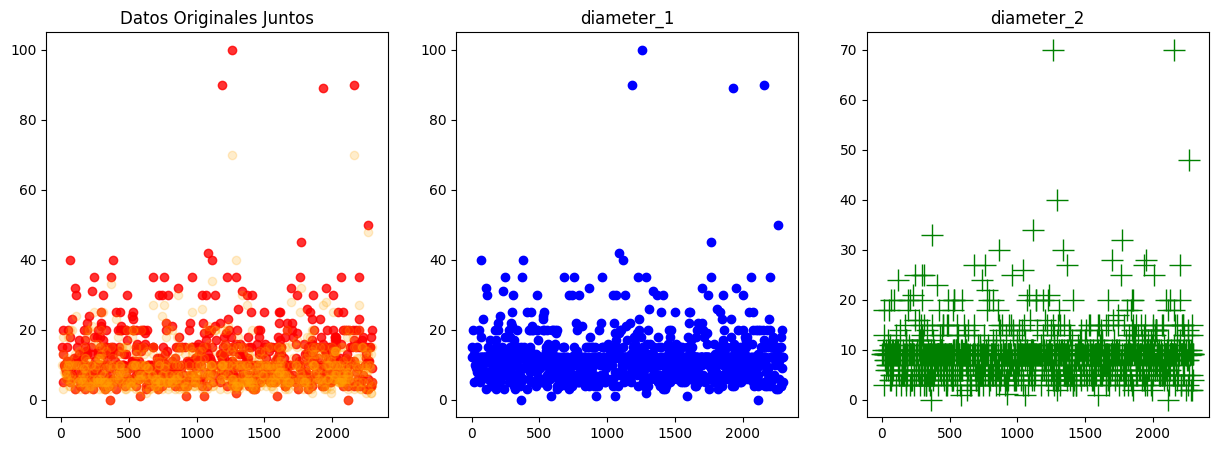

In [12]:
# graficar la distribución de los datos antes y después de la imputación
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)

ax1.set_title("Datos Originales Juntos")
ax1.plot(df['diameter_1'], linewidth=0, marker="o", color="red", alpha=0.8, markersize=6)
ax1.plot(df['diameter_2'], linewidth=0, marker="o", color="orange", alpha=0.2, markersize=6)

ax2.set_title("diameter_1")
ax2.plot(df_imputado["diameter_1"], linewidth=0, marker="o", color="blue", markersize=6)

ax3.set_title("diameter_2")
ax3.plot(df_imputado["diameter_2"], linewidth=0, marker="+", color="green", markersize=16)
plt.show()

**Observación:**

Aquí puedo ver visualizar los datos extremos.

<hr style="border: 2px solid red;">

['smoke', 'drink', 'age', 'pesticide', 'skin_cancer_history', 'cancer_history', 'has_piped_water', 'has_sewage_system', 'fitspatrick', 'diameter_1', 'diameter_2', 'itch', 'grew', 'hurt', 'changed', 'bleed', 'elevation', 'biopsed', 'diagnostic_encoded']


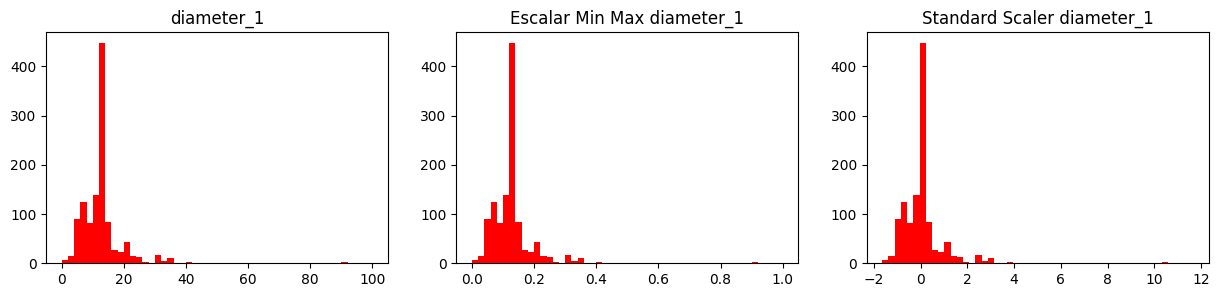

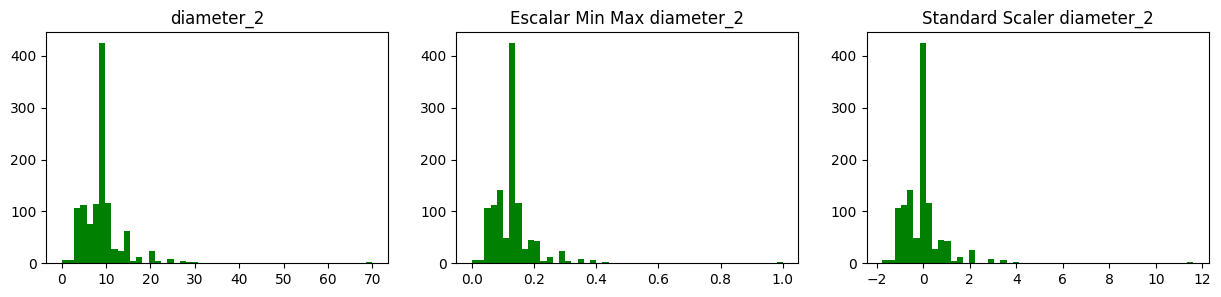

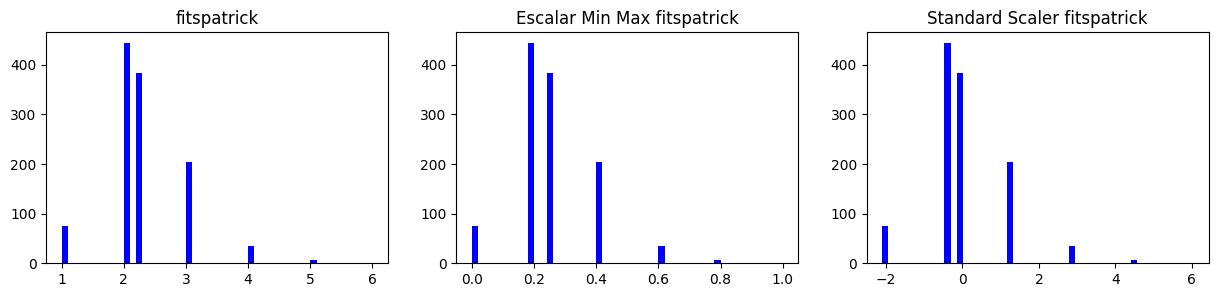

In [13]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# sólo voy a obtener los valores estadísticos de las columnas numéricas
lista_col_numerico = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
print(lista_col_numerico)
# lo que quiero graficar lo trasformo en DataFrames
df_graficar = df_imputado[lista_col_numerico]
# normalizar los datos de las columnas numéricas, usando el df imputado
datos_min_max = MinMaxScaler().fit_transform(df_graficar)
datos_standard_scaler = StandardScaler().fit_transform(df_graficar)

# convierte vectores de numpy a DataFrames para graficarlos
df_min_max = pd.DataFrame(datos_min_max, columns=[lista_col_numerico])
df_standard_scaler = pd.DataFrame(datos_standard_scaler, columns=[lista_col_numerico])

def graficar_histogramas(df_graf:pd.DataFrame, df_min_max:pd.DataFrame, df_standard_scaler:pd.DataFrame, col_a_graficar:str, color_graf:str):

    # crea una figura con 3 subfiguras para mostrar histogramas
    fig = plt.figure(figsize=(15, 3))
    ax1 = fig.add_subplot(1, 3, 1)
    ax2 = fig.add_subplot(1, 3, 2)
    ax3 = fig.add_subplot(1, 3, 3)
    # crea y personaliza series de datos de los histogramas
    ax1.set_title(col_a_graficar)
    ax1.hist(df_graf[col_a_graficar], color=color_graf, bins=50)

    ax2.set_title("Escalar Min Max " + col_a_graficar)
    ax2.hist(df_min_max[col_a_graficar], color=color_graf, bins=50)

    ax3.set_title("Standard Scaler " + col_a_graficar)
    ax3.hist(df_standard_scaler[col_a_graficar], color=color_graf, bins=50)
    plt.show()

graficar_histogramas(df_graficar, df_min_max, df_standard_scaler, 'diameter_1', 'red')
graficar_histogramas(df_graficar, df_min_max, df_standard_scaler, 'diameter_2', 'green')
graficar_histogramas(df_graficar, df_min_max, df_standard_scaler, 'fitspatrick', 'blue')

**Observación:**

Aquí puedo ver cuál normalización es mejor utilizar, para cada uno de los descriptores.

<hr style="border: 2px solid red;">


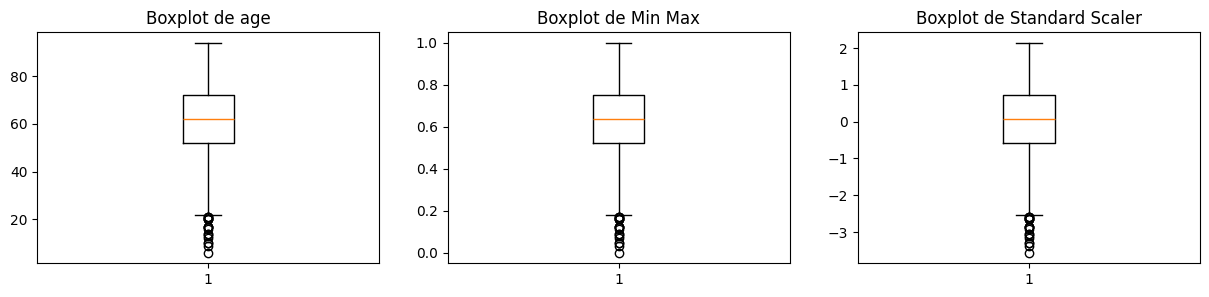

In [14]:
def graficar_boxplot(descriptor, max_min, std_scaler, col_a_graficar:str):
    # crea una figura con 3 subfiguras para mostrar boxplots
    fig = plt.figure(figsize=(15, 3))
    ax1 = fig.add_subplot(1, 3, 1)
    ax2 = fig.add_subplot(1, 3, 2)
    ax3 = fig.add_subplot(1, 3, 3)

    ax1.set_title(f"Boxplot de {col_a_graficar}")
    ax1.boxplot(descriptor)

    ax2.set_title("Boxplot de Min Max")
    ax2.boxplot(max_min)

    ax3.set_title("Boxplot de Standard Scaler")
    ax3.boxplot(std_scaler)
    plt.show()

graficar_boxplot(df_graficar['age'], df_min_max['age'], df_standard_scaler['age'], 'age')

**Observación:**

Aquí podemos observar la distribución mayoritaria de edad, que estaría cerca de los 60 años.
<hr style="border: 2px solid red;">

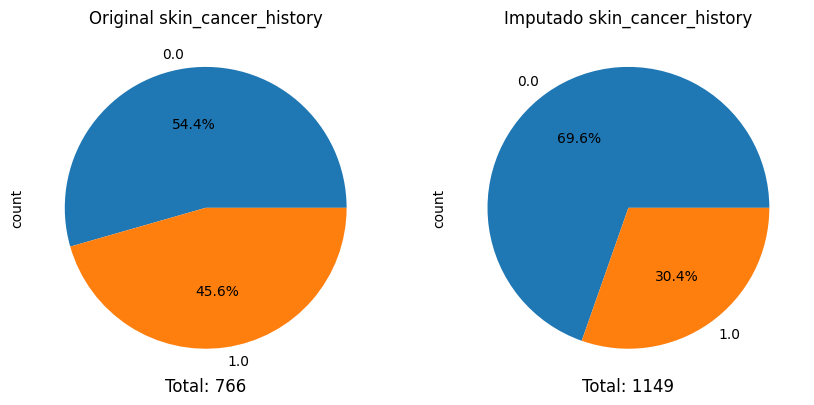

In [15]:
# graficar la distribución de los datos antes y después de la imputación, especialmente para valores categóricos verdadero falso
def graficar_torta(descriptor1, descriptor2, col:str):
    fig = plt.figure(figsize=(10, 5))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)

    ax1.set_title(f"Original {col}")
    ax1.text(0, -1.3, f'Total: {descriptor1.count()}', ha='center', fontsize=12)
    descriptor1.value_counts().plot.pie(autopct='%1.1f%%', ax=ax1)

    ax2.set_title(f"Imputado {col}")
    ax2.text(0, -1.3, f'Total: {descriptor2.count()}', ha='center', fontsize=12)
    descriptor2.value_counts().plot.pie(autopct='%1.1f%%', ax=ax2)

    plt.show()

# graficar_torta(df, df_imputado, 'cancer_history')
graficar_torta(df['skin_cancer_history'], df_imputado['skin_cancer_history'], 'skin_cancer_history')
# graficar_torta(df, df_imputado, 'changed')



**Observación:**

Aquí podemos observar cómo afecta la imputación seleccionada, que en estos casos fue la most_frequent y afecta mucho en la distribución del gráfico. En este caso yo eliminaría los NaN cuando la respuesta es True o False.



<div style="height: 5px; background: linear-gradient(to right, cyan, lime); margin-bottom: 20px;"></div>
2 ptos Cree una función que permita hacer scatter plots y/o box plots para dos descriptores datos. La función debe recibir como argumento las dos variables, y el tipo de gráfico que se desea obtener. La función debe recibir como argumento la decisión de visualizar o guardar los gráficos realizados. Usted puede agregar más argumentos para obtener visualizaciones más personalizadas. Usando dicha función, genere visualizaciones para 5 de los descriptores de la base de datos entregada.


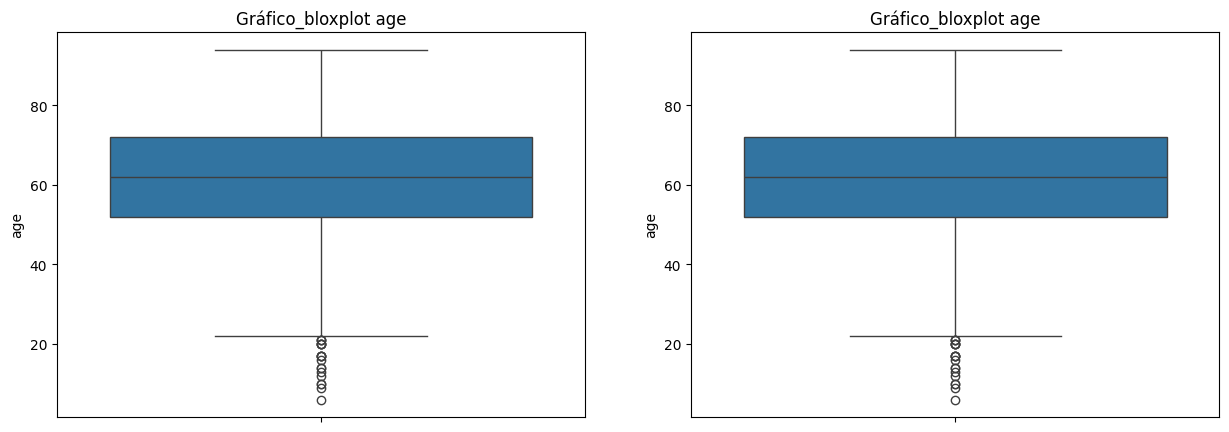

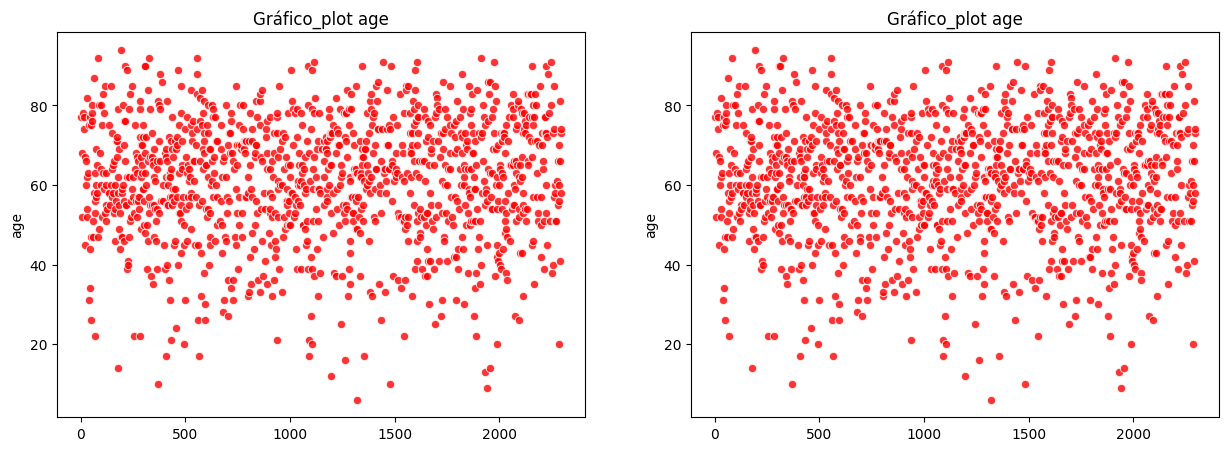

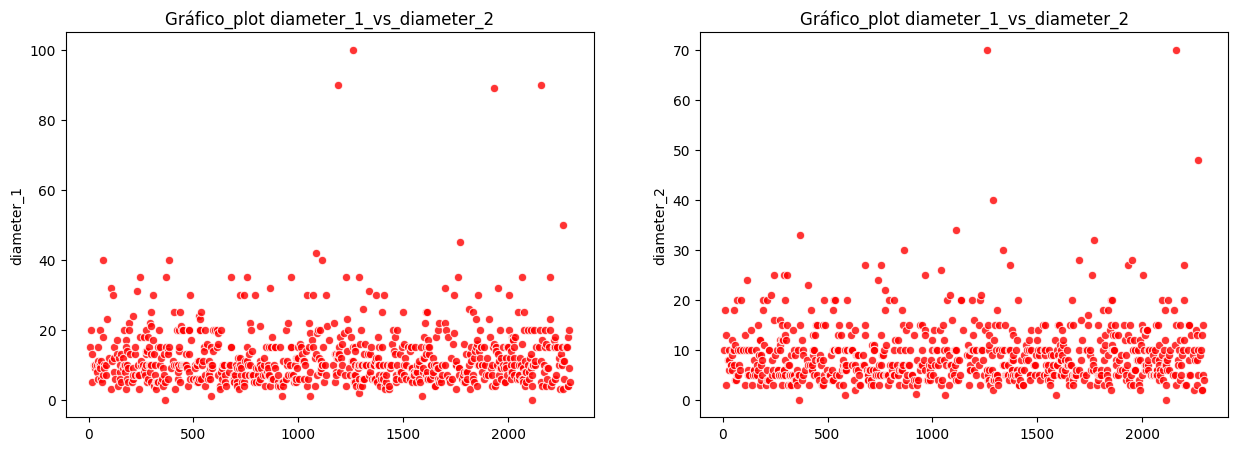

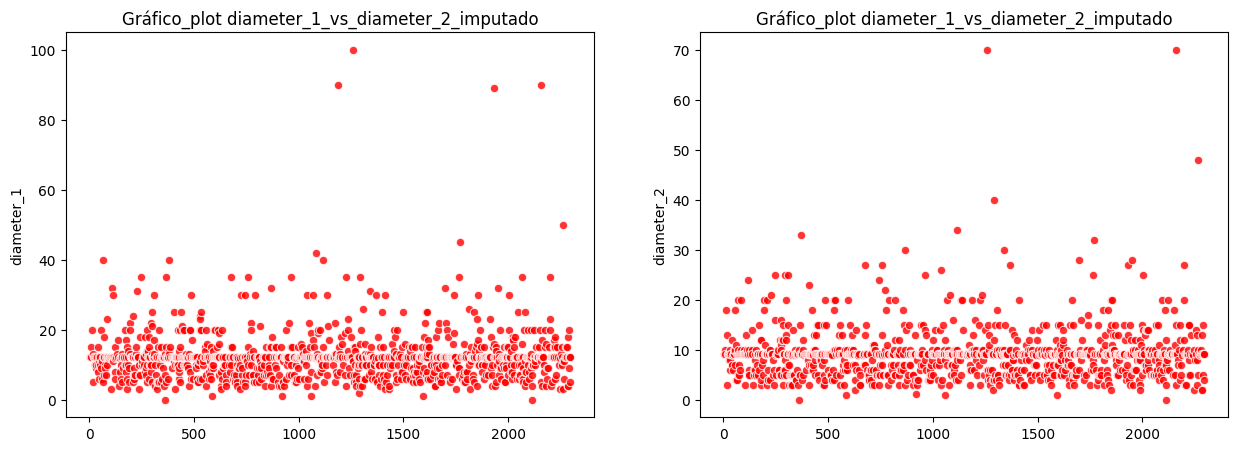

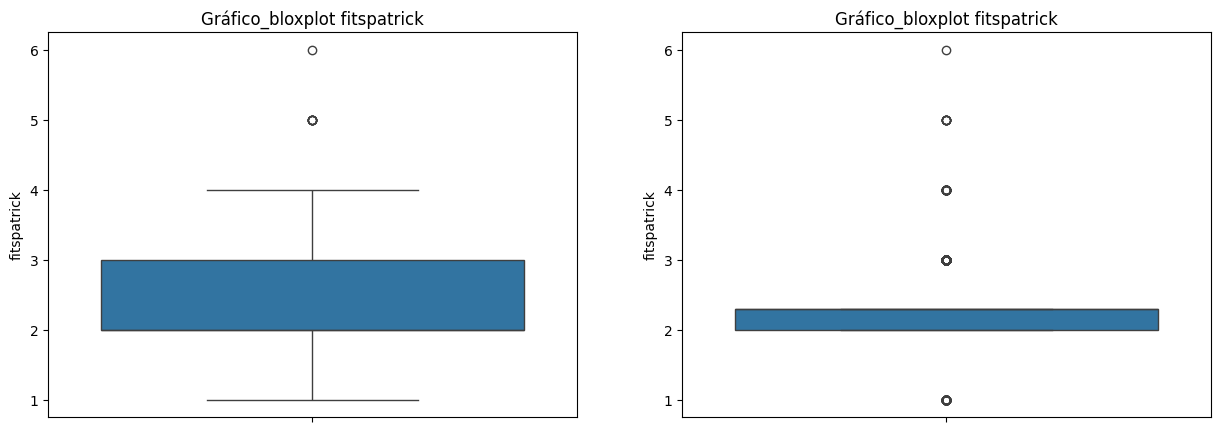

In [16]:

def graficar_plot_bloxplot(descriptor1, descriptor2, tipo_grafico, guardar:bool=False, titulo:str=None):
    fig = plt.figure(figsize=(15, 5))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)

    if tipo_grafico == 'plot':
        ax1.set_title(f"Gráfico_{tipo_grafico} {titulo}")
        sns.lineplot(data=descriptor1, ax=ax1, linewidth=0, marker="o", color="red", alpha=0.8, markersize=6)

        ax2.set_title(f"Gráfico_{tipo_grafico} {titulo}")
        sns.lineplot(data=descriptor2, ax=ax2, linewidth=0, marker="o", color="red", alpha=0.8, markersize=6)

    if tipo_grafico == 'bloxplot':

        ax1.set_title(f"Gráfico_{tipo_grafico} {titulo}")
        sns.boxplot(data=descriptor1, ax=ax1)

        ax2.set_title(f"Gráfico_{tipo_grafico} {titulo}")
        sns.boxplot(data=descriptor2, ax=ax2)

    if guardar:
        if not os.path.exists('graficos'):
            os.makedirs('graficos')
        plt.savefig(f'graficos/grafico_{tipo_grafico}_{titulo}.png')
    plt.show()


graficar_plot_bloxplot(df['age'], df_imputado['age'], 'bloxplot', guardar=True, titulo='age')
graficar_plot_bloxplot(df['age'], df_imputado['age'], 'plot', guardar=True, titulo='age')
graficar_plot_bloxplot(df['diameter_1'], df['diameter_2'], 'plot', guardar=True, titulo='diameter_1_vs_diameter_2')
graficar_plot_bloxplot(df_imputado['diameter_1'], df_imputado['diameter_2'], 'plot', guardar=True, titulo='diameter_1_vs_diameter_2_imputado')
graficar_plot_bloxplot(df['fitspatrick'], df_imputado['fitspatrick'], 'bloxplot', guardar=True, titulo='fitspatrick')


<div style="height: 5px; background: linear-gradient(to right, cyan, lime); margin-bottom: 20px;"></div>
3 ptos Aplique normalización z o escalamiento a los datos. Genere una función que permita aplicar estas transformaciones a los datos, como argumento se debe indicar qué tipo de estrategia se usará para cada descriptor. La función debe retornar el dataframe modificado.


In [17]:
def normalizacion_datos(df:pd.DataFrame, tipo_normalizacion:str):
    columnas = df.columns.tolist()
    if tipo_normalizacion == 'MinMax':
        datos_normalizados = MinMaxScaler().fit_transform(df)
    elif tipo_normalizacion == 'StandardScaler':
        datos_normalizados = StandardScaler().fit_transform(df)

    # convierte vectores de numpy a DataFrames
    df_result= pd.DataFrame(datos_normalizados, columns=[columnas])
    return df_result

df_datos_a_normalizar = df_graficar[['diameter_1', 'diameter_2', 'age', 'fitspatrick']]
df_MinMax = normalizacion_datos(df_datos_a_normalizar, 'MinMax')
df_StandardScaler = normalizacion_datos(df_datos_a_normalizar, 'StandardScaler')




<div style="height: 5px; background: linear-gradient(to right, cyan, lime); margin-bottom: 20px;"></div>
3 ptos Genere sets de entrenamiento y testeo, con separación estratificada. Genere una función que aplique este procesamiento. No olvide fijar la semilla aleatoria para poder replicar los resultados.

In [18]:

def generar_train_test(df:pd.DataFrame, col_target:str, del_col:list, rand_st:int, test_tam:float):
    X = df_imputado.drop(del_col, axis=1)
    y = df_imputado[col_target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_tam, random_state=rand_st)
    return X_train, X_test, y_train, y_test

col_eliminar = ['diagnostic', 'diagnostic_encoded', 'biopsed', 'background_father', 'background_mother', 'gender']
random_state = 19
X_train, X_test, y_train, y_test = generar_train_test(df_imputado, 'diagnostic_encoded', col_eliminar, random_state, 0.2)


In [19]:
# tengo un problema con este perfomance warning del df.drop(columns..) asi que lo voy a ignorar, son solo 3 drops
import warnings
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)


<div style="height: 5px; background: linear-gradient(to right, cyan, lime); margin-bottom: 20px;"></div>
8 ptos Consolide todas las funciones en una clase. Esta clase tendrá por nombre preprocesamiento. Algunos de los parámetros que se usan en las funciones antes creadas pueden ser entregadas en la inicialización de la clase. Agregue una función que aplique todo el procesamiento, denomine a esta función ejecutar procesamiento.

In [20]:
class Preprocesamiento:
    def __init__(self, ruta:str, muestra:bool, columnas:list, sep:str, nombre_col_y:str, rand_state_sample, porcentaje:float=0.5, ruta_config:str='data/datos_guardados.yaml'):
        self.ruta = ruta
        self.muestra = muestra
        self.columnas = columnas
        self.sep = sep
        self.rand_state_sample = rand_state_sample
        self.porcentaje = porcentaje
        self.ruta_config = ruta_config
        self.nombre_col_y = nombre_col_y
        self._df = None

    def cargar_datos(self):
        if not os.path.exists(self.ruta):
            raise FileNotFoundError(f'No se encontró el archivo en la ruta: {self.ruta}')
        df = pd.read_csv(self.ruta, sep=self.sep)
        if self.muestra:
            df = df.sample(frac=self.porcentaje, random_state=self.rand_state_sample)
        df_final = df[self.columnas]
        return df_final


    def cambiar_UNK_a_nan(self, df:pd.DataFrame):
        pd.set_option('future.no_silent_downcasting', True) # para que no muestre el warning de que se va a eliminar en futuras versiones

        columnas = [col for col in df.columns.tolist() if df[col].dtype == 'object']
        col_con_UNK = [col for col in columnas if df[col].astype(str).str.contains('UNK').any()]
        col_TF = [x for x in columnas if set(df[x].dropna().unique()) == {'True', 'False',}]
        col_hat_true_false = list(set(col_con_UNK + col_TF))

        for col in col_hat_true_false:
            df.loc[:, col] = df[col].replace({'UNK': np.nan, 'True': True, 'False': False})

        return df

    def transf_true_false(self, df:pd.DataFrame):
        columnas = df.columns.tolist()
        col_true_false = [x for x in columnas if (df[x].dtype == 'object' or df[x].dtype == 'bool') and (set(df[x].dropna().unique()) == {True, False,})]
        for col in col_true_false:
            df[col] = df[col].map({True: 1, False: 0})
            df[col] = df[col].infer_objects(copy=False)
        return df

    # función de apoyo para ver valores únicos y % de nulos de un dataframe
    def obtener_analisis(self, df:pd.DataFrame):
        unicos = {}
        for col in df.columns.tolist():
            lista_unique = df[col].unique().tolist()
            unicos[col] = lista_unique

        porc_nulos = {}
        for col in df.columns.tolist():
            nulo = df[col].isnull().sum()
            porc_nulos[col] = round(float(nulo/df.shape[0]), 2)

        datos_analisis = {
                        'Columna': list(unicos.keys()),
                        'Valor único': list(unicos.values()),
                        'Porcentaje nulos': list(porc_nulos.values()),
                        }
        df_datos = pd.DataFrame(datos_analisis)
        return df_datos

    def separar_datos_yaml(self, col:str):
        with open(self.ruta_config, 'r') as file:
            datos = yaml.safe_load(file)
        datos_imputar = datos[col] # lista de dict
        clave = []
        valores = []
        for valor in datos_imputar:
            for key, value in valor.items():  # Iterar sobre cada diccionario dentro de la lista
                clave.append(key)
                valores.append(value)
        return clave, valores

    def codificar_label_encoder(self, df: pd.DataFrame):
        encoder = LabelEncoder()
        new_col = f"{self.nombre_col_y}_encoded"
        df[new_col] = encoder.fit_transform(df[self.nombre_col_y])
        df = df.drop(columns=self.nombre_col_y)
        lista_label = encoder.classes_
        lista_num = encoder.transform(encoder.classes_)
        label_num = dict(zip(lista_label, lista_num))
        label_num = {k: int(v) for k, v in label_num.items()}

        return df, label_num, new_col

    # tengo que poner los setters y getters de self._df, aproveche de poner las funciones de cargar_datos, cambiar_UNK_a_nan y transf_true_false
    @property
    def df(self):
        if self._df is None:
            df_ = self.cargar_datos()
            df_ = self.cambiar_UNK_a_nan(df_)
            df_ = self.transf_true_false(df_)
            self._df = df_
        return self._df

    @df.setter
    def df(self, value):
        self._df = value


    def diagnositico_estadistico(self, descriptor, media:bool=False, desv:bool=False, perdidos:bool=False ,max:bool=False , min:bool=False, redondear:int=2, del_NaN:bool=True) -> dict:
    # por defecto están todos seteados en False
        respuesta = {}
        # consulto primero por los valores perdidos, es decir, los NaN
        if perdidos:
            respuesta['perdidos'] = int(np.sum(descriptor.isnull()))

        # eliminar si hay valores Nan
        if del_NaN:
            d = descriptor.dropna()
        else:
            d = descriptor

        if media:
            respuesta['media'] = float(d.mean().round(redondear))
        if desv:
            respuesta['desviacion'] = float(d.std().round(redondear))
        if max:
            respuesta['maximo'] = float(d.max().round(redondear))
        if min:
            respuesta['minimo'] = float(d.min().round(redondear))

        return respuesta

    def imputar_datos(self, df:pd.DataFrame, lista_col:list, estrategias:list) -> pd.DataFrame:
        df_copy = df.copy()
        for col, estrategia in zip(lista_col, estrategias):
            if estrategia == 'most_frequent':
                df_copy[col] = df_copy[col].fillna(df_copy[col].mode()[0])
            elif estrategia == 'mean':
                df_copy[col] = df_copy[col].fillna(df_copy[col].mean().round(2))
            elif estrategia == 'median':
                df_copy[col] = df_copy[col].fillna(df_copy[col].median().round(2))
            elif estrategia == 'constant_zero':
                df_copy[col] = df_copy[col].fillna(0)
            elif estrategia == 'dropna':
                df_copy[col] = df_copy[col].dropna()
        return df_copy

    def normalizacion_datos(self, df:pd.DataFrame, tipo_normalizacion:str):
        columnas = df.columns.tolist()
        if tipo_normalizacion == 'MinMax':
            datos_normalizados = MinMaxScaler().fit_transform(df)
        elif tipo_normalizacion == 'StandardScaler':
            datos_normalizados = StandardScaler().fit_transform(df)
        # convierte vectores de numpy a DataFrames
        df_result= pd.DataFrame(datos_normalizados, columns=[columnas])
        return df_result

    def generar_train_test(self, df, col_target:str, rand_st:int, test_tam:float):
        X = df.drop(col_target, axis=1)
        y = df[col_target]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_tam, random_state=rand_st)
        return X_train, X_test, y_train, y_test


    def graficar_histogramas(self, df_graf:pd.DataFrame, df_graf2:pd.DataFrame, df_graf3:pd.DataFrame, col_a_graficar:list, color_graf:str):

        # crea una figura con 3 subfiguras para mostrar histogramas
        fig = plt.figure(figsize=(15, 3))
        ax1 = fig.add_subplot(1, 3, 1)
        ax2 = fig.add_subplot(1, 3, 2)
        ax3 = fig.add_subplot(1, 3, 3)
        # crea y personaliza series de datos de los histogramas
        ax1.set_title(col_a_graficar[0].capitalize())
        ax1.hist(df_graf[col_a_graficar[0]], color=color_graf, bins=50)

        ax2.set_title(col_a_graficar[1].capitalize())
        ax2.hist(df_graf2[col_a_graficar[1]], color=color_graf, bins=50)

        ax3.set_title(col_a_graficar[2].capitalize())
        ax3.hist(df_graf3[col_a_graficar[2]], color=color_graf, bins=50)
        plt.show()

    def graficar_boxplot(self, descriptor, max_min, std_scaler, col_a_graficar:str):
        # crea una figura con 3 subfiguras para mostrar boxplots
        fig = plt.figure(figsize=(15, 3))
        ax1 = fig.add_subplot(1, 3, 1)
        ax2 = fig.add_subplot(1, 3, 2)
        ax3 = fig.add_subplot(1, 3, 3)

        ax1.set_title(f"Boxplot de {col_a_graficar}")
        ax1.boxplot(descriptor)

        ax2.set_title("Boxplot de Min Max")
        ax2.boxplot(max_min)

        ax3.set_title("Boxplot de Standard Scaler")
        ax3.boxplot(std_scaler)
        plt.show()

    def graficar_torta(self, descriptor1, descriptor2, titulo:list):
        fig = plt.figure(figsize=(10, 5))
        ax1 = fig.add_subplot(1, 2, 1)
        ax2 = fig.add_subplot(1, 2, 2)

        ax1.set_title(titulo[0].capitalize())
        ax1.text(0, -1.3, f'Total: {descriptor1.count()}', ha='center', fontsize=12)
        descriptor1.value_counts().plot.pie(autopct='%1.1f%%', ax=ax1)

        ax2.set_title(titulo[1].capitalize())
        ax2.text(0, -1.3, f'Total: {descriptor2.count()}', ha='center', fontsize=12)
        descriptor2.value_counts().plot.pie(autopct='%1.1f%%', ax=ax2)

        plt.show()

    def graficar_plot_bloxplot(self, descriptor1, descriptor2, tipo_grafico, guardar:bool=False, titulo:str=None):
        fig = plt.figure(figsize=(15, 5))
        ax1 = fig.add_subplot(1, 2, 1)
        ax2 = fig.add_subplot(1, 2, 2)

        if tipo_grafico == 'plot':
            ax1.set_title(f"Gráfico_{tipo_grafico} {titulo}")
            sns.lineplot(data=descriptor1, ax=ax1, linewidth=0, marker="o", color="red", alpha=0.8, markersize=6)

            ax2.set_title(f"Gráfico_{tipo_grafico} {titulo}")
            sns.lineplot(data=descriptor2, ax=ax2, linewidth=0, marker="o", color="red", alpha=0.8, markersize=6)

        if tipo_grafico == 'bloxplot':

            ax1.set_title(f"Gráfico_{tipo_grafico} {titulo}")
            sns.boxplot(data=descriptor1, ax=ax1)

            ax2.set_title(f"Gráfico_{tipo_grafico} {titulo}")
            sns.boxplot(data=descriptor2, ax=ax2)

        if guardar:
            if not os.path.exists('graficos'):
                os.makedirs('graficos')
            plt.savefig(f'graficos/grafico_{tipo_grafico}_{titulo}.png')
        plt.show()

    ### Ejecutar el procesamiento de los datos
    def ejecutar_procesamiento(self, col_a_imputar_in_file, tipo_escalado, normalizar:bool=True, eliminar_col=None):
        self.cargar_datos()
        df = self.df

        if eliminar_col is not None:
            df = df.drop(columns=eliminar_col) # elimino las columnas que no quiero procesar

        # armo el labelEncoder de la columna target
        df_encoder, dict_clase_num, nombre_col_y_cod= self.codificar_label_encoder(df)


        col_a_imputar, estrategia = self.separar_datos_yaml(col_a_imputar_in_file) # lo dejé en un archivo yaml con las columnas a imputar y la estrategia
        if eliminar_col is not None:
            col_a_imputar = [col for col in col_a_imputar if col not in eliminar_col] # de aquí también elimino las columnas que no quiero imputar pq ya las eliminé arriba.

        df_imputado = self.imputar_datos(df_encoder, col_a_imputar, estrategia)
        # no quiero normalizar si uso logistic regression o Naive Bayes
        if normalizar:
            df_datos_a_normalizar = self.normalizacion_datos(df_imputado, tipo_escalado)
        else:
            df_datos_a_normalizar = df_imputado

        return df_datos_a_normalizar, dict_clase_num, nombre_col_y_cod

    def calcular_prior_clase(self, df:pd.DataFrame, col_target:str):
        if df[col_target].count() == 0:
            raise ValueError('No hay datos en la columna target')
        pd_prior = df[col_target].value_counts() / df[col_target].count()
        return pd_prior




## Corre la clase de Preprocesamiento

In [21]:
ruta_datos = 'data/metadatos.csv'
columnas_a_usar = ['smoke', 'drink', 'background_father', 'background_mother', 'age', 'pesticide', 'gender', 'skin_cancer_history', 'cancer_history', 'has_piped_water', 'has_sewage_system', 'fitspatrick', 'region', 'diameter_1', 'diameter_2', 'diagnostic', 'itch', 'grew', 'hurt', 'changed', 'bleed', 'elevation', 'biopsed']
col_clase = 'diagnostic'
ruta_config_yaml = 'data/datos_guardados.yaml'
col_a_imputar_in_file ='Col_imputar'
tipo_escalado = 'StandardScaler'
porcentaje_muestra = 0.5
porc_test = 0.3
rand_state_muestra=42
rand_state_test=42
# no quiero normalizar si uso logistic regression o Naive Bayes, por eso eliminé las columnas que no quiero procesar pq son no categoricas
eliminar_col = ['biopsed', 'background_father', 'background_mother', 'age','gender','region','fitspatrick','diameter_1', 'diameter_2', 'bleed', 'elevation']
normalizado = False


preproc = Preprocesamiento(ruta=ruta_datos, muestra=True, columnas=columnas_a_usar, sep=',', nombre_col_y=col_clase, rand_state_sample = rand_state_muestra, porcentaje=porcentaje_muestra, ruta_config=ruta_config_yaml)

df_imputado, dict_clase_num, nombre_col_y_cod = preproc.ejecutar_procesamiento(col_a_imputar_in_file, tipo_escalado, normalizado, eliminar_col)

X_train, X_test, y_train, y_test = preproc.generar_train_test(df_imputado, nombre_col_y_cod, rand_state_test, porc_test)

print(f'La codificación de la clase {col_clase} es: {dict_clase_num}')
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'{preproc.df.shape}')
preproc.obtener_analisis(preproc.df)

La codificación de la clase diagnostic es: {'ACK': 0, 'BCC': 1, 'MEL': 2, 'NEV': 3, 'SCC': 4, 'SEK': 5}
X_train shape: (804, 11)
X_test shape: (345, 11)
(1149, 23)


,Columna,Valor único,Porcentaje nulos
0,smoke,"[nan, 0.0, 1.0]",0.33
1,drink,"[nan, 0.0, 1.0]",0.33
2,background_father,"[nan, POMERANIA, GERMANY, ITALY, BRAZIL, NETHE...",0.39
3,background_mother,"[nan, POMERANIA, GERMANY, ITALY, BRAZIL, FRANC...",0.38
4,age,"[39, 58, 56, 71, 79, 85, 46, 61, 78, 83, 80, 5...",0.00
5,pesticide,"[nan, 1.0, 0.0]",0.33
6,gender,"[nan, FEMALE, MALE]",0.33
7,skin_cancer_history,"[nan, 1.0, 0.0]",0.33
8,cancer_history,"[nan, 1.0, 0.0]",0.33
9,has_piped_water,"[nan, 0.0, 1.0]",0.33


In [22]:
df_y_prior = preproc.calcular_prior_clase(df_imputado, nombre_col_y_cod)
df_y_prior


,count
diagnostic_encoded,
1,0.368146
0,0.312446
3,0.103568
5,0.102698
4,0.087903
2,0.025239


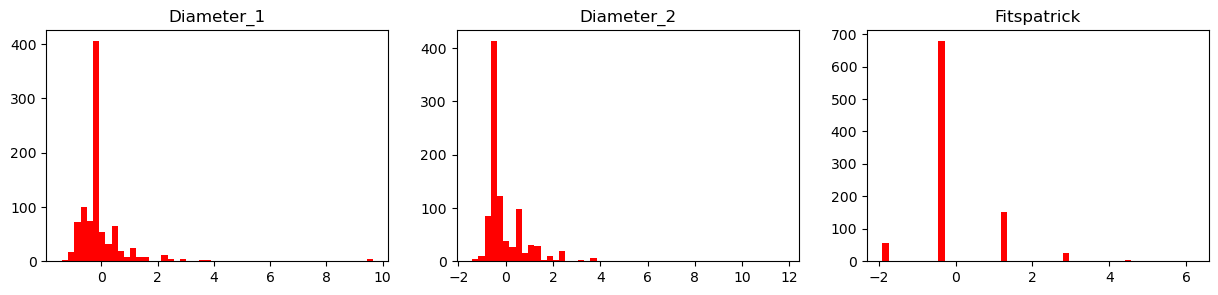

In [ ]:
# # graficar X_train =====>>>> no correr esto, pq no tomé en cuenta estas columnas, dado que quiero datos categoricos
# col_a_graf = ['diameter_1', 'diameter_2', 'fitspatrick']
# preproc.graficar_histogramas(X_train, X_train, X_train, col_a_graf, 'red')

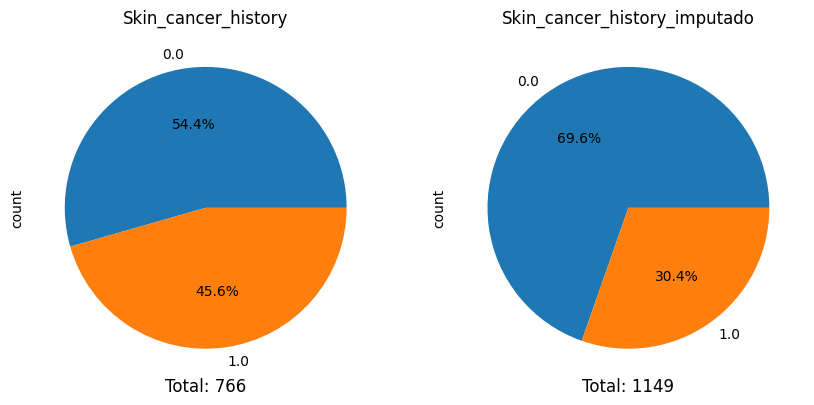

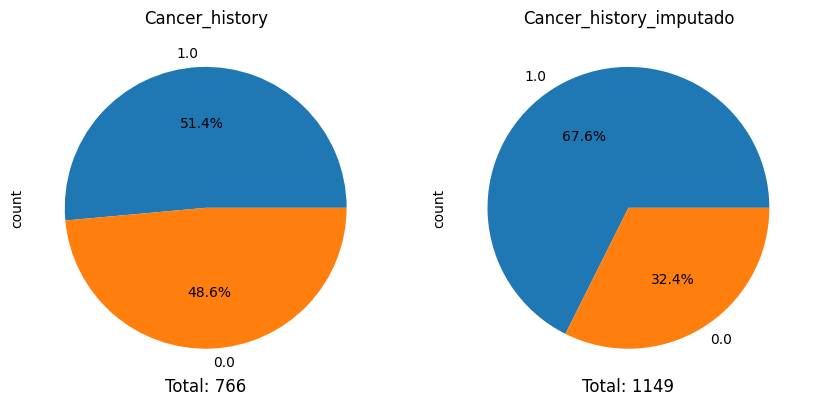

In [23]:
# graficar torta de algo booleano, ver la imputación con la estratia, como cambiaron los datos
col_a_graf = ['skin_cancer_history', 'cancer_history']
estrategias = ['most_frequent', 'most_frequent']
titulo_0 = [col_a_graf[0],f'{col_a_graf[0]}_imputado']
titulo_1 = [col_a_graf[1],f'{col_a_graf[1]}_imputado']
df = preproc.df
df_imputado = preproc.imputar_datos(df, col_a_graf, estrategias)
preproc.graficar_torta(df[col_a_graf[0]], df_imputado[col_a_graf[0]], titulo_0)
preproc.graficar_torta(df[col_a_graf[1]], df_imputado[col_a_graf[1]], titulo_1)

**Observación importante:** Cabe mancionar que cuando están los datos originales, plt automaticamente no toma en cuenta los NaN celdas. Entonces cuando visualizamos el gráfico imputado vemos la diferencia con todos los datos, tomando en cuenta que se rellenará con los datos más frecuente cuando imputamos.

<div style="height: 5px; background: linear-gradient(to right, cyan, lime); margin-bottom: 20px;"></div>
#3.2 Entrenamiento de modelos (35 puntos)

10 ptos Ajuste los clasificadores naive Bayes (desde sklearn.naive bayes.GaussianNB) y regresión logística (desde sklearn.linear model.LogisticRegression ). Genere una función con nombre clasificador que reciba como argumento: (i) el tipo de clasificador que desea ajustar, (ii) el nombre de la dirección donde se guardara el modelo y (iii) los datos de entrenamiento. La función solo debe ajustar y guardar el modelo.


In [30]:
from sklearn.naive_bayes import GaussianNB
#from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
import joblib
import datetime

def clasificador(tipo_clasif: str, subcarpeta: str, X_train, y_train, max_iter_RL=None, priors_nb=None, **kwargs):
    if tipo_clasif == 'naive_bayes':
        modelo = GaussianNB(priors=priors_nb)

    elif tipo_clasif == 'logistic_regression':
        modelo = LogisticRegression(**kwargs)

    else:
        raise ValueError("Favor sólo ingrese estos datos: naive_bayes o logistic_regression.")

    # entrenar el modelo
    modelo.fit(X_train, y_train)

    # guardar el modelo en una ruta... tuve que poner la fecha pq me estaban sobreescribiendo los modelos
    fecha = datetime.datetime.now().strftime("%y-%m-%d_%f")

    ruta_guardar = f'{subcarpeta}/{fecha}_{tipo_clasif}_model.pkl'
    # if os.path.exists(ruta_guardar):
    #     os.remove(ruta_guardar)
    joblib.dump(modelo, ruta_guardar)
    print(f"el modelo se guardo en: {ruta_guardar}")
    return ruta_guardar

In [ ]:
fecha = datetime.datetime.now().strftime("%y-%m-%d_%f")
fecha

'24-11-26_905565'

#### Aprendiendo lo que contiene el Modelo Naive Bayes
Ver documentación [aquí](https://scikit-learn.org/1.5/modules/generated/sklearn.naive_bayes.GaussianNB.html)
Interesante es este código, aquí estaría cómo se invoca.

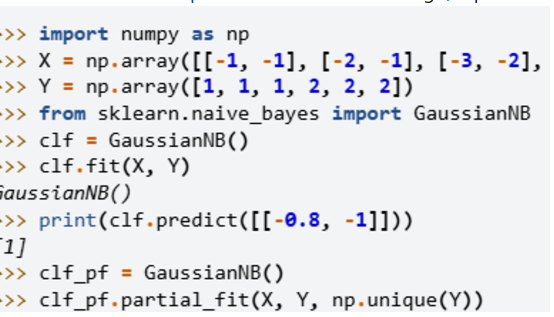


**observación priors en Naive Bayes**
El parámetro priors representa las probabilidades iniciales que se asigna a cada clase. Es decir, la probabilidad a priori de que una instancia pertenezca a una clase antes de observar ninguna característica.

Por defecto, GaussianNB calcula automáticamente las probabilidades a priori basándose en la proporción de cada clase en el conjunto de datos de entrenamiento. Sin embargo, se puede definir estos valores manualmente.

In [31]:
ruta_modelo = clasificador('naive_bayes', 'models', X_train, y_train)
modelo_ng = joblib.load(ruta_modelo)
modelo_ng.theta_

el modelo se guardo en: models/24-11-27_025024_naive_bayes_model.pkl


array([[0.03614458, 0.09236948, 0.14859438, 0.18875502, 0.81124498,
        0.82329317, 0.83534137, 0.78313253, 0.16465863, 0.09236948,
        0.04417671],
       [0.1650165 , 0.27722772, 0.45214521, 0.4950495 , 0.52145215,
        0.61386139, 0.57755776, 0.76237624, 0.48844884, 0.38283828,
        0.08250825],
       [0.04761905, 0.38095238, 0.42857143, 0.0952381 , 0.52380952,
        0.52380952, 0.47619048, 0.19047619, 0.76190476, 0.        ,
        0.61904762],
       [0.        , 0.09459459, 0.06756757, 0.14864865, 0.85135135,
        0.90540541, 0.87837838, 0.06756757, 0.51351351, 0.02702703,
        0.06756757],
       [0.2173913 , 0.28985507, 0.4057971 , 0.49275362, 0.47826087,
        0.65217391, 0.68115942, 0.7826087 , 0.4057971 , 0.26086957,
        0.11594203],
       [0.01136364, 0.04545455, 0.01136364, 0.17045455, 0.88636364,
        0.90909091, 0.90909091, 0.27272727, 0.43181818, 0.01136364,
        0.01136364]])

### Aprendiendo logistic regression

Ver [aqui](https://scikit-learn.org/1.5/modules/linear_model.html#logistic-regression)

Se invoca de la misma manera que las regressiones que hemos visto de sklearn, según lo que he leído en la documentación, la "Binary Case" es cuando el target y toma valores entre set {0,1} pero en nuestro caso, nuestro target es "Multinominal Case" dado que parametrizamos las lesiones en [NEV, BCC, ACK, SEK, SCC, MEL]	esto: {'ACK': 0, 'BCC': 1, 'MEL': 2, 'NEV': 3, 'SCC': 4, 'SEK': 5} hicimos un codificar_label_encoder. Como indica la doc, el caso binario puede ser extendido a K  clases, para que sea un multinomial.

Hay unas penalidades, según lo indicado en la doc.

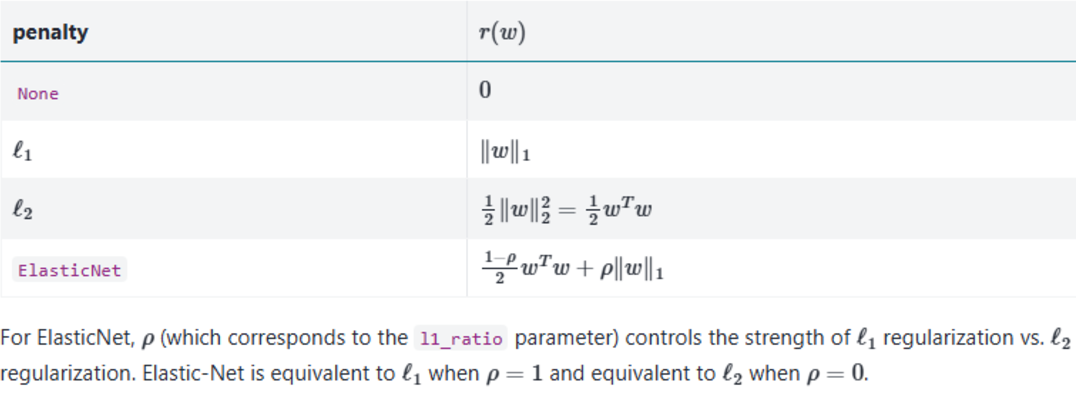

In [32]:
ruta_modelo = clasificador('logistic_regression', 'models', X_train, y_train, 1000)
modelo_lg = joblib.load(ruta_modelo)
modelo_lg.coef_

el modelo se guardo en: models/24-11-27_554697_logistic_regression_model.pkl


array([[-0.23446537, -0.1507151 , -0.00607167, -0.31615792,  0.37325555,
        -0.43161787,  0.39010822,  1.50857017, -1.33540048, -0.15682239,
        -0.14464241],
       [ 0.99057136,  0.16976709,  0.81251721,  0.64624949, -0.62239104,
         0.02770667, -0.55165111,  0.95169857, -0.00278955,  1.44874047,
        -0.31156026],
       [-0.34173925,  0.6490627 ,  0.38702331, -0.85142087, -0.09298681,
         0.27423398, -0.97675161, -0.8635011 ,  0.60631958, -0.64205956,
         1.79328873],
       [-1.07694226, -0.24163314, -0.42608273, -0.22305863,  0.4365792 ,
         0.61338953,  0.19590252, -2.13132434,  0.66910908, -0.42176883,
        -0.18959818],
       [ 1.22000757,  0.2735838 ,  0.61296056,  0.68286542, -0.74755134,
        -0.47491953,  0.21938355,  1.24230651, -0.33833836,  0.8166557 ,
         0.11316281],
       [-0.55743206, -0.70006534, -1.38034668,  0.06152253,  0.65309444,
        -0.00879279,  0.72300843, -0.70774981,  0.40109973, -1.04474539,
        -1.260

<div style="height: 5px; background: linear-gradient(to right, cyan, lime); margin-bottom: 20px;"></div>
10 ptos Cree una función que tenga por nombre evaluar rendimiento, esta función debe recibir la dirección del modelo, los datos que desea evaluar (entrenamiento o test) y el tipo de análisis. Los análisis posibles son: (i) mostrar la matriz de confusión y (ii) mostrar las métricas de evaluación (accuracy, recall, precision y F1-score).


In [33]:
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, accuracy_score

def evaluar_rendimiento(ruta_modelo, tipo_analisis, X_test, y_test):
    # Recargar modelos
    modelo = joblib.load(ruta_modelo)
    if tipo_analisis == 'matriz_confusion':
        y_pred = modelo.predict(X_test)
        matriz_confusion = confusion_matrix(y_test, y_pred)
        return matriz_confusion

    elif tipo_analisis == 'metricas_evaluacion':
        metricas = {}
        y_pred = modelo.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        metricas['accuracy'] = accuracy
        recall = recall_score(y_test, y_pred, average='weighted')
        metricas['recall'] = recall
        precision = precision_score(y_test, y_pred, average='weighted', zero_division=0) # en la doc dice: weighted': Calculate metrics for each label, and find their average weighted by support (the number of true instances for each label).
        metricas['precision'] = precision
        f1 = f1_score(y_test, y_pred, average='weighted')
        metricas['f1_score'] = f1
        return metricas

    else:
        raise ValueError("Favor sólo ingrese estos datos: matriz_confusion o metricas_evaluacion.")


<div style="height: 5px; background: linear-gradient(to right, cyan, lime); margin-bottom: 20px;"></div>
<hr style="border: 2px solid orange;">

**Esta parte no lo alcancé a solucionar, esperar hasta la clase del martes 26.nov.**

15 ptos
En naive Bayes modifique: priors de acuerdo a la descripción de la librería. Entregue un análisis de los resultados y seleccione un modelo. También puede aplicar procedimientos para seleccionar los descriptores que se incluyen en el modelo final.
<hr style="border: 2px solid orange;">

In [34]:
nb_ruta_modelo = clasificador('naive_bayes', 'data', X_train, y_train)
nb_modelo = joblib.load(nb_ruta_modelo)

#df_y_prior = preproc.calcular_prior_clase(df_imputado, nombre_col_y_cod)
_y_prior = df_y_prior.to_numpy()
print(f'Calculo a priori de la clase y: {_y_prior}')

probabilidad_prior = nb_modelo.class_prior_
print(f'Probabilidad a priori: {probabilidad_prior}')

nb_metrics = evaluar_rendimiento(nb_ruta_modelo, 'metricas_evaluacion', X_test, y_test)
pd_nb_metrics = pd.DataFrame(nb_metrics, index=['Naive_Bayes'])

nb_ruta_modelo_y = clasificador('naive_bayes', 'data', X_train, y_train, priors_nb=_y_prior)
nb_modelo_y = joblib.load(nb_ruta_modelo_y)
nb_metrics_y = evaluar_rendimiento(nb_ruta_modelo_y, 'metricas_evaluacion', X_test, y_test)
pd_nb_metrics_y = pd.DataFrame(nb_metrics_y, index=['Naive_Bayes_y'])

# ahora puedo concatenar los dos dataframes y ver las métricas de los dos modelos
pd_nb_metrics_comb = pd.concat([pd_nb_metrics, pd_nb_metrics_y])
pd_nb_metrics_comb


el modelo se guardo en: data/24-11-27_395635_naive_bayes_model.pkl
Calculo a priori de la clase y: [0.36814621 0.3124456  0.10356832 0.102698   0.08790252 0.02523934]
Probabilidad a priori: [0.30970149 0.37686567 0.0261194  0.0920398  0.0858209  0.10945274]
el modelo se guardo en: data/24-11-27_444035_naive_bayes_model.pkl


,accuracy,recall,precision,f1_score
Naive_Bayes,0.252174,0.252174,0.343727,0.218796
Naive_Bayes_y,0.231884,0.231884,0.286681,0.197118


**obs.** Tomé los valores que me dan desde el dataframe imputado, antes de la division del X_train, y simplemente calculé el porcentaje del resultado de la clase. Como el prior es una probabilidad del target, puede ser que el valor que calculé según los datos, puede ser mejor, y así fue, todos las métricas bajaron.
<hr style="border: 2px solid orange;">

 Use estas funciones para probar distintos modelos, explore los siguientes argumentos en la regresión logística: penalty, C, class weight, l1 ratio.
**esta parte no pude hacerla, no entendía la documentación .. lo siento.**
 <hr style="border: 2px solid red;">


In [ ]:
def obtener_datos_penalty(ruta_config_yaml:str, nombre_variable:str, nombre_penalty:str):
    with open(ruta_config_yaml, "r") as file:
        yaml_file = yaml.safe_load(file)
    alphas = yaml_file[nombre_variable][nombre_penalty]
    array_alphas = np.array(alphas)
    return array_alphas

# están las penaltys alphas, alpha, l1_ratio, max_iter
array_alphas = obtener_datos_penalty(ruta_config_yaml, 'penalty', 'alphas')
array_alphas

array([0.1, 0.5, 1. , 2.5, 5. ])

bonus

In [38]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

modelo_tree = DecisionTreeClassifier()
modelo_tree.fit(X_train,y_train)
y_pred = modelo_tree.predict(X_test)
accuracy_tree = accuracy_score(y_test,y_pred)

modelo_forest = RandomForestClassifier()
modelo_forest.fit(X_train,y_train)
y_pred= modelo_forest.predict(X_test)
accuracy_forest = accuracy_score(y_test,y_pred)

print(f"Accuracy desicion tree : {accuracy_tree}")
print(f"Accuracy forest tree : {accuracy_forest}")


Accuracy desicion tree : 0.5159420289855072
Accuracy forest tree : 0.5420289855072464


### 3.3	Entrega
* La actividad deberá entregarse en un archivo comprimido donde incluya archivos Jupyter notebook (.ipynb), Python (.py) y otros archivos para gestionar parámetros (ejemplo: .yaml, .json). El archivo comprimido debe subirse a la plataforma del curso y subirse a su repositorio del curso en Githuba. No subir el archivo con los datos originales.
* La actividad debe realizarse en los grupos ya formados para el curso. Se recomienda tener instalado el complemento Live share.
* La actividad debe ser subida a la plataforma antes del martes 26 a las 21:59 P.M.
